In [1]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import os
import torch

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata, run_SLAT_AGF_contrast
from scSLAT.viz import match_3D_multi, hist, Sankey, build_3D
from scSLAT.metrics import region_statistics

In [4]:
adata_1=sc.read_h5ad('D:\ppppaper\data\BrCa\BrCa_section2_add_tumor_region.h5ad')
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 3987 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region_real', 'tumor_region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'tumor_region_colors', 'tumor_region_real_colors'
    obsm: 'spatial'

In [5]:
adata_2=sc.read_h5ad('D:\ppppaper\data\BrCa\BrCa_section1_add_tumor_region.h5ad')
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Cell_type_colors', 'spatial'
    obsm: 'spatial'

In [6]:
print(adata_1.obs_names)

Index(['AAACAACGAATAGTTC-1', 'AAACAAGTATCTCCCA-1', 'AAACAATCTACTAGCA-1',
       'AAACACCAATAACTGC-1', 'AAACAGAGCGACTCCT-1', 'AAACAGCTTTCAGAAG-1',
       'AAACAGGGTCTATATT-1', 'AAACAGTGTTCCTGGG-1', 'AAACATTTCCCGGATT-1',
       'AAACCACTACACAGAT-1',
       ...
       'TTGTGTATGCCACCAA-1', 'TTGTGTTTCCCGAAAG-1', 'TTGTTAGCAAATTCGA-1',
       'TTGTTCAGTGTGCTAC-1', 'TTGTTGTGTGTCAAGA-1', 'TTGTTTCACATCCAGG-1',
       'TTGTTTCATTAGTCTA-1', 'TTGTTTCCATACAACT-1', 'TTGTTTGTATTACACG-1',
       'TTGTTTGTGTAAATTC-1'],
      dtype='object', length=3987)


In [ ]:
csv_data = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\MY_BAS2_colData.csv", index_col=0)
csv_data['banksy'] = csv_data['clust_M0_lam0.9_k50_res0.8_smooth']

category_mapping = {
    1: "cluster1", 2: "cluster2", 3: "cluster3", 4: "cluster4", 5: "cluster5",
    6: "cluster6", 7: "cluster7", 8: "cluster8", 9: "cluster9", 10: "cluster10",
    11: "cluster11", 12: "cluster12", 13: "cluster13", 14: "cluster14", 15: "cluster15",
    16: "cluster16", 17: "cluster17", 18: "cluster18", 19: "cluster19", 20: "cluster20",
}
csv_data['banksy'] = csv_data['clust_M0_lam0.9_k50_res0.8_smooth'].map(category_mapping)

# 查看映射后的列
print(csv_data[['banksy', 'clust_M0_lam0.9_k50_res0.8_smooth']].head())

                       banksy  clust_M0_lam0.9_k50_res0.8_smooth
AAACAACGAATAGTTC-1  cluster13                                 13
AAACAAGTATCTCCCA-1   cluster3                                  3
AAACAATCTACTAGCA-1   cluster6                                  6
AAACACCAATAACTGC-1  cluster10                                 10
AAACAGAGCGACTCCT-1   cluster1                                  1


In [8]:
adata_1.obs['banksy_cluster'] = csv_data['banksy']

In [9]:
csv_data = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\MY_BAS1_colData.csv", index_col=0)
csv_data['banksy'] = csv_data['clust_M0_lam0.9_k50_res0.8_smooth']
category_mapping = {
    1: "cluster1", 2: "cluster2", 3: "cluster3", 4: "cluster4", 5: "cluster5",
    6: "cluster6", 7: "cluster7", 8: "cluster8", 9: "cluster9", 10: "cluster10",
    11: "cluster11", 12: "cluster12", 13: "cluster13", 14: "cluster14", 15: "cluster15",
    16: "cluster16", 17: "cluster17", 18: "cluster18", 19: "cluster19", 20: "cluster20",
}
csv_data['banksy'] = csv_data['clust_M0_lam0.9_k50_res0.8_smooth'].map(category_mapping)
# 查看映射后的列
print(csv_data[['banksy', 'clust_M0_lam0.9_k50_res0.8_smooth']].head())

                       banksy  clust_M0_lam0.9_k50_res0.8_smooth
AAACAAGTATCTCCCA-1   cluster3                                  3
AAACACCAATAACTGC-1  cluster10                                 10
AAACAGAGCGACTCCT-1   cluster1                                  1
AAACAGGGTCTATATT-1   cluster3                                  3
AAACAGTGTTCCTGGG-1   cluster9                                  9


In [10]:
adata_2.obs['banksy_cluster'] = csv_data['banksy']

In [11]:
csv_data_3 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\my_pca_bas2.csv", index_col=0)
print(csv_data_3.head())

                          PC1        PC2       PC3       PC4       PC5  \
AAACAACGAATAGTTC-1   6.956023   7.168249 -1.948964  1.855671  1.148938   
AAACAAGTATCTCCCA-1  28.937112  -9.610465  7.469282 -2.732965  2.569288   
AAACAATCTACTAGCA-1  -9.344989  16.701968 -1.394540  3.936842 -2.424846   
AAACACCAATAACTGC-1 -19.766271 -21.771196 -7.395016  9.864027  0.220041   
AAACAGAGCGACTCCT-1  20.435340  -7.738515  6.861659  0.945331 -5.544557   

                          PC6       PC7       PC8       PC9      PC10  \
AAACAACGAATAGTTC-1 -10.444825 -3.695274  5.133667 -1.038425  7.862041   
AAACAAGTATCTCCCA-1   7.529422 -3.682379  3.355591 -8.127088  2.521252   
AAACAATCTACTAGCA-1 -12.647899 -1.687805  3.631130 -2.443904  0.846728   
AAACACCAATAACTGC-1   1.282241  4.354681  3.008712  6.234778 -1.576206   
AAACAGAGCGACTCCT-1  -2.841407  3.040788 -2.124235 -2.425979 -0.559639   

                        PC11      PC12      PC13      PC14      PC15  \
AAACAACGAATAGTTC-1 -6.365836 -0.141446  3.69

In [12]:
pca_array = csv_data_3.values  # 转换为NumPy数组
pca_array

array([[  6.95602293,   7.16824908,  -1.9489644 , ...,   0.17422389,
          1.31355972,   0.54005614],
       [ 28.93711154,  -9.610465  ,   7.46928193, ...,  -5.69892394,
         -5.34221633,   4.20204686],
       [ -9.34498873,  16.70196783,  -1.39454016, ...,  -1.24056857,
          0.22560897,   0.85084021],
       ...,
       [ 10.73805336,   4.78342262,  -6.73998825, ...,   0.99179163,
         -0.90949124,   1.28172801],
       [-26.51218779, -24.23307864,   0.61288864, ...,   3.00527089,
         -1.11527469,  -2.1101971 ],
       [ -0.45499348,  11.46550539,  -6.66116515, ...,  -2.12948298,
          0.8883853 ,   0.32367973]])

In [13]:
adata_1.obsm["banksy_pca"] = pca_array

In [14]:
csv_data_3 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\my_pca_bas1.csv", index_col=0)
print(csv_data_3.head())

                          PC1        PC2        PC3        PC4        PC5  \
AAACAAGTATCTCCCA-1  29.948704  -8.957412  -1.591078  -4.457651   3.029295   
AAACACCAATAACTGC-1 -22.261268 -19.079826  -7.574731   8.686018   0.791727   
AAACAGAGCGACTCCT-1  32.132361 -11.641943  13.233642  -0.054187  -4.483119   
AAACAGGGTCTATATT-1  31.810883  -4.518811 -17.204586  -5.521334  15.303093   
AAACAGTGTTCCTGGG-1 -23.110424 -23.519808   1.597266  13.654353   5.631552   

                         PC6       PC7        PC8       PC9      PC10  \
AAACAAGTATCTCCCA-1  2.740559 -9.000388   6.650836 -1.974667 -6.298880   
AAACACCAATAACTGC-1  2.332792  4.803220   0.995202  5.673457 -3.226104   
AAACAGAGCGACTCCT-1 -4.259220  2.595948 -12.780635 -0.791610  1.755669   
AAACAGGGTCTATATT-1  0.367827  5.219130   6.912204  2.962752 -5.792373   
AAACAGTGTTCCTGGG-1  2.853905 -1.275701   4.312470  0.540384  8.532406   

                        PC11      PC12      PC13      PC14       PC15  \
AAACAAGTATCTCCCA-1 -0.303

In [15]:
pca_array = csv_data_3.values  # 转换为NumPy数组
adata_2.obsm["banksy_pca"] = pca_array

In [16]:
csv_data_2 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\MY_BAS2_UMAP.csv", index_col=0)
# 查看映射后的列
print(csv_data_2.head())

                           V1         V2
AAACAACGAATAGTTC-1 -19.487555 -10.658409
AAACAAGTATCTCCCA-1   5.332906   6.153532
AAACAATCTACTAGCA-1 -22.738715  -2.253688
AAACACCAATAACTGC-1  13.092134 -14.667409
AAACAGAGCGACTCCT-1  -8.159031  10.670488


In [17]:
UMAP_1 = csv_data_2[['V1']]
UMAP_2 = csv_data_2[['V2']]

print(UMAP_1.index.equals(adata_1.obs_names)) 
print(UMAP_2.index.equals(adata_1.obs_names)) 
adata_1.obs['UMAP_1'] = UMAP_1
adata_1.obs['UMAP_2'] = UMAP_2

True
True


In [18]:
csv_data_2 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\MY_BAS1_UMAP.csv", index_col=0)
# 查看映射后的列
print(csv_data_2.head())

                           V1         V2
AAACAAGTATCTCCCA-1   6.770526   6.099798
AAACACCAATAACTGC-1  13.507869 -13.902785
AAACAGAGCGACTCCT-1  -4.789454   4.770245
AAACAGGGTCTATATT-1   7.492524  -9.250361
AAACAGTGTTCCTGGG-1  22.835622 -12.815917


In [19]:
UMAP_1 = csv_data_2[['V1']]
UMAP_2 = csv_data_2[['V2']]

print(UMAP_1.index.equals(adata_2.obs_names)) 
print(UMAP_2.index.equals(adata_2.obs_names)) 
adata_2.obs['UMAP_1'] = UMAP_1
adata_2.obs['UMAP_2'] = UMAP_2

True
True


In [25]:
# adata_1.write('D:\ppppaper\data\BrCa\MY_BrCa_section2_BANKSY.h5ad')
# adata_2.write('D:\ppppaper\data\BrCa\MY_BrCa_section1_BANKSY.h5ad')

In [20]:
adata_1

AnnData object with n_obs × n_vars = 3987 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region_real', 'tumor_region', 'banksy_cluster', 'UMAP_1', 'UMAP_2'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'tumor_region_colors', 'tumor_region_real_colors'
    obsm: 'spatial', 'banksy_pca'

In [21]:
adata_2

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Cell_type', 'tumor_region', 'banksy_cluster', 'UMAP_1', 'UMAP_2'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Cell_type_colors', 'spatial'
    obsm: 'spatial', 'banksy_pca'

In [14]:
spot_size = 200
pathology_color = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B",
    "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF", "#AEC7E8", "#FFBB78",
    "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94", "#F7B6D2", "#C7C7C7",
    "#DBDB8D", "#9EDAE5", "#1F9B99", "#FFCD56", "#33A02C", "#FB9A99",
    "#A6CEE3"
]

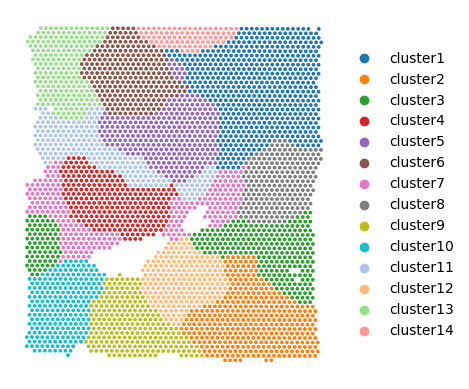

In [27]:
# adata_2.obs['banksy_cluster'] = adata_2.obs['banksy_cluster'].astype(str)
sc.pl.spatial(adata_1, img_key=None, color=['banksy_cluster'], title=[''],
                show=True, frameon=False, palette = pathology_color,
                spot_size=spot_size)

In [7]:
adata_2.obs['banksy_cluster']

AAACAAGTATCTCCCA-1     1
AAACACCAATAACTGC-1    10
AAACAGAGCGACTCCT-1    11
AAACAGGGTCTATATT-1     1
AAACAGTGTTCCTGGG-1    10
                      ..
TTGTTGTGTGTCAAGA-1     7
TTGTTTCACATCCAGG-1    10
TTGTTTCATTAGTCTA-1    10
TTGTTTCCATACAACT-1     6
TTGTTTGTGTAAATTC-1     9
Name: banksy_cluster, Length: 3798, dtype: object

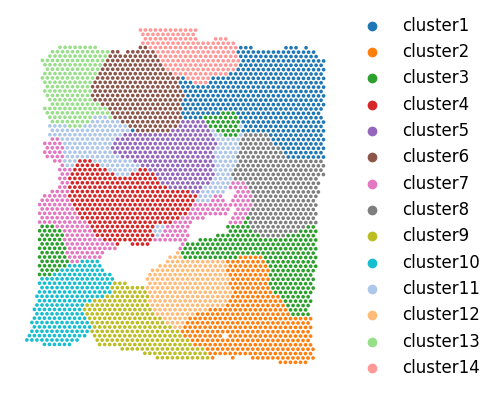

In [28]:
sc.pl.spatial(adata_2, img_key=None, color=['banksy_cluster'], title=[''],
                legend_fontsize=12, show=True, frameon=False, palette = pathology_color,
                spot_size=spot_size)

In [12]:
csv_data_3 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\pca_data_cd3.csv", index_col=0)
print(csv_data_3.head())

                          PC1        PC2       PC3        PC4        PC5  \
AAACAAGTATCTCCCA-1  -8.216823 -18.781031 -4.782411  -3.581487  -0.705047   
AAACAATCTACTAGCA-1  -9.183995 -13.121281 -8.088030  -3.043613   0.521183   
AAACACCAATAACTGC-1 -20.030035  18.526729 -2.659989   1.339477  -1.548978   
AAACAGAGCGACTCCT-1   1.480980  -8.030743  2.945790 -19.713173  11.750071   
AAACAGCTTTCAGAAG-1  -2.569349   9.071625  1.916213   1.789043  -0.258291   

                         PC6       PC7       PC8       PC9      PC10  \
AAACAAGTATCTCCCA-1 -5.811187  1.149271 -7.698784 -3.501936  0.522870   
AAACAATCTACTAGCA-1 -0.467903  4.515129 -0.547209  3.495745 -8.767069   
AAACACCAATAACTGC-1  1.442224 -2.379372 -3.806163 -0.181256  1.891287   
AAACAGAGCGACTCCT-1  2.134546 -6.456125  4.293116  5.959644  0.772515   
AAACAGCTTTCAGAAG-1 -0.206929 -1.853849 -4.136971 -0.083040  4.119431   

                        PC11      PC12      PC13      PC14      PC15  \
AAACAAGTATCTCCCA-1  0.061161  3.091182

In [13]:
pca_array = csv_data_3.values  # 转换为NumPy数组
pca_array

array([[ -8.21682252, -18.78103083,  -4.78241062, ...,  -2.29571124,
          3.5270758 ,  -8.97617116],
       [ -9.18399522, -13.12128137,  -8.08802959, ...,  -1.80168408,
         -7.1263792 ,  -2.47926534],
       [-20.03003521,  18.52672895,  -2.65998879, ...,   0.4023681 ,
         -0.95943609,  -0.59374868],
       ...,
       [-17.46919115,  14.57250859,  -5.9721282 , ...,   1.46866923,
          0.57049147,  -1.13220837],
       [ -7.67504332,  13.57162132,   2.74120191, ...,  -0.70165971,
         -4.66874481,  -3.36899183],
       [ -9.11849666, -20.70746561,  -4.19669668, ...,  -0.61313134,
         -2.55240685,  -1.67494825]])

In [14]:
adata_1.obsm["banksy_pca"] = pca_array

In [15]:
adata_1

AnnData object with n_obs × n_vars = 4727 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'banksy_cluster'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'banksy_cluster_colors'
    obsm: 'spatial', 'banksy_pca'

In [16]:
csv_data_3 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\pca_data_bas1.csv", index_col=0)
print(csv_data_3.head())

                          PC1        PC2        PC3       PC4       PC5  \
AAACAAGTATCTCCCA-1  29.226567   8.911740 -12.205351 -0.951242  1.489846   
AAACACCAATAACTGC-1 -21.993080  20.617323  -0.109422  2.725585 -3.210068   
AAACAGAGCGACTCCT-1  37.566950  11.686464  13.806760 -2.671172  6.794796   
AAACAGGGTCTATATT-1  29.543542   6.126775 -12.888289  7.349476 -7.745500   
AAACAGTGTTCCTGGG-1 -23.193368  27.091747   2.565342 -9.978266 -5.059546   

                         PC6        PC7       PC8        PC9      PC10  \
AAACAAGTATCTCCCA-1 -3.586007  -0.857311  4.750469  -3.544641  1.084785   
AAACACCAATAACTGC-1  2.699496  -6.347008 -7.942563  -4.244712  7.914416   
AAACAGAGCGACTCCT-1  5.940703   6.296676 -8.322299   4.918221 -0.330359   
AAACAGGGTCTATATT-1 -5.395982 -10.136934  2.687679 -11.817613 -2.393983   
AAACAGTGTTCCTGGG-1  4.380314  -7.868981 -0.601775  -0.374372 -7.155574   

                         PC11      PC12      PC13      PC14      PC15  \
AAACAAGTATCTCCCA-1   4.479602 -

In [17]:
pca_array = csv_data_3.values  # 转换为NumPy数组
pca_array

array([[ 29.22656665,   8.91174048, -12.20535059, ...,  -1.32085485,
          2.23663021,  -2.5464306 ],
       [-21.99308035,  20.61732252,  -0.10942224, ...,   4.65680495,
         -1.84165798,  -4.60497318],
       [ 37.56694976,  11.68646404,  13.80675962, ..., -11.16886857,
        -13.39918249,   3.18458817],
       ...,
       [-27.6291113 ,  23.38378363,   2.69554342, ...,   1.12547504,
         -0.53225373,  -1.82148819],
       [  8.88002529,  -2.37676065,  -9.5888231 , ...,   2.14266047,
         -0.8656309 ,   2.9192385 ],
       [ -2.88785606, -12.23400959,   4.47558558, ...,  -0.33833074,
         -0.49186366,   4.1662659 ]])

In [18]:
adata_2.obsm["banksy_pca"] = pca_array

In [19]:
# adata_1.write('D:\ppppaper\data\IDC\CD3_BANKSY.h5ad')
# adata_2.write('D:\ppppaper\data\BrCa\BrCa_section1_BANKSY.h5ad')

In [6]:
adata_com = sc.concat([adata_1, adata_2], label='slice', keys=['CD3', 'BAS1'])

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [13]:
adata_com

AnnData object with n_obs × n_vars = 8525 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'slice'
    obsm: 'spatial', 'banksy_pca'

In [14]:
csv_data_3 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\BAS1_CD3_PCA_com.csv", index_col=0)
print(csv_data_3.head())

                          PC1        PC2       PC3        PC4        PC5  \
AAACAAGTATCTCCCA-1  -8.216823 -18.781031 -4.782411  -3.581487  -0.705047   
AAACAATCTACTAGCA-1  -9.183995 -13.121281 -8.088030  -3.043613   0.521183   
AAACACCAATAACTGC-1 -20.030035  18.526729 -2.659989   1.339477  -1.548978   
AAACAGAGCGACTCCT-1   1.480980  -8.030743  2.945790 -19.713173  11.750071   
AAACAGCTTTCAGAAG-1  -2.569349   9.071625  1.916213   1.789043  -0.258291   

                         PC6       PC7       PC8       PC9      PC10  \
AAACAAGTATCTCCCA-1 -5.811187  1.149271 -7.698784 -3.501936  0.522870   
AAACAATCTACTAGCA-1 -0.467903  4.515129 -0.547209  3.495745 -8.767069   
AAACACCAATAACTGC-1  1.442224 -2.379372 -3.806163 -0.181256  1.891287   
AAACAGAGCGACTCCT-1  2.134546 -6.456125  4.293116  5.959644  0.772515   
AAACAGCTTTCAGAAG-1 -0.206929 -1.853849 -4.136971 -0.083040  4.119431   

                        PC11      PC12      PC13      PC14      PC15  \
AAACAAGTATCTCCCA-1  0.061161  3.091182

In [15]:
pca_array = csv_data_3.values  # 转换为NumPy数组
pca_array

array([[ -8.21682252, -18.78103083,  -4.78241062, ...,  -2.29571124,
          3.5270758 ,  -8.97617116],
       [ -9.18399522, -13.12128137,  -8.08802959, ...,  -1.80168408,
         -7.1263792 ,  -2.47926534],
       [-20.03003521,  18.52672895,  -2.65998879, ...,   0.4023681 ,
         -0.95943609,  -0.59374868],
       ...,
       [-27.6291113 ,  23.38378363,   2.69554342, ...,   1.12547504,
         -0.53225373,  -1.82148819],
       [  8.88002529,  -2.37676065,  -9.5888231 , ...,   2.14266047,
         -0.8656309 ,   2.9192385 ],
       [ -2.88785606, -12.23400959,   4.47558558, ...,  -0.33833074,
         -0.49186366,   4.1662659 ]])

In [16]:
pca_array.shape

(8525, 20)

In [17]:
adata_com.obsm["banksy_pca"] = pca_array

In [18]:
csv_data_2 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\BAS1_CD3_UMAP_com.csv", index_col=0)
# 查看映射后的列
print(csv_data_2.head())

                           V1         V2
AAACAAGTATCTCCCA-1  -6.966239  18.214986
AAACAATCTACTAGCA-1 -11.345305 -20.216058
AAACACCAATAACTGC-1  20.057080  -1.077793
AAACAGAGCGACTCCT-1 -10.651481   5.586991
AAACAGCTTTCAGAAG-1  13.779265   4.672859


In [19]:
UMAP_1 = csv_data_2[['V1']]
UMAP_2 = csv_data_2[['V2']]

print(UMAP_1.index.equals(adata_com.obs_names)) 
print(UMAP_2.index.equals(adata_com.obs_names)) 
adata_com.obs['UMAP_1'] = UMAP_1
adata_com.obs['UMAP_2'] = UMAP_2

True
True


In [20]:
adata_com

AnnData object with n_obs × n_vars = 8525 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'slice', 'UMAP_1', 'UMAP_2'
    obsm: 'spatial', 'banksy_pca'

In [38]:
csv_data = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\BAS1_CD3_com_clust.csv", index_col=0)
csv_data['banksy'] = csv_data['clust_M0_lam0.9_k50_res0.5']

category_mapping = {
    1: "cluster1", 2: "cluster2", 3: "cluster3", 4: "cluster4", 5: "cluster5",
    6: "cluster6", 7: "cluster7", 8: "cluster8", 9: "cluster9", 10: "cluster10",
    11: "cluster11", 12: "cluster12", 13: "cluster13", 14: "cluster14", 15: "cluster15",
    16: "cluster16", 17: "cluster17", 18: "cluster18", 19: "cluster19", 20: "cluster20",
}
csv_data['banksy'] = csv_data['clust_M0_lam0.9_k50_res0.5'].map(category_mapping)

# 查看映射后的列
print(csv_data[0:4840][['banksy', 'clust_M0_lam0.9_k50_res0.5']].head())

                       banksy  clust_M0_lam0.9_k50_res0.5
AAACAAGTATCTCCCA-1  cluster13                          13
AAACAATCTACTAGCA-1   cluster5                           5
AAACACCAATAACTGC-1   cluster2                           2
AAACAGAGCGACTCCT-1   cluster1                           1
AAACAGCTTTCAGAAG-1   cluster2                           2


In [39]:
csv_data['banksy'].shape

(8525,)

In [40]:
adata_com.obs['banksy_cluster'] = csv_data['banksy']

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


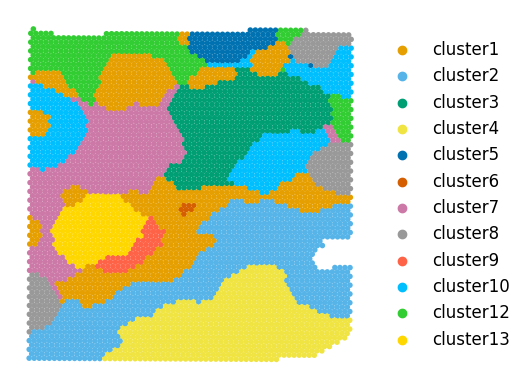

In [41]:
sc.pl.spatial(adata_com[0:4727,:], img_key=None, color=['banksy_cluster'], title=[''],
                legend_fontsize=12, show=True, frameon=False, palette = pathology_color,
                spot_size=spot_size)

In [42]:
adata_com[4727:4740,:].obs['banksy_cluster']

AAACAAGTATCTCCCA-1     cluster1
AAACACCAATAACTGC-1    cluster11
AAACAGAGCGACTCCT-1     cluster1
AAACAGGGTCTATATT-1     cluster1
AAACAGTGTTCCTGGG-1    cluster11
AAACATTTCCCGGATT-1     cluster9
AAACCCGAACGAAATC-1     cluster1
AAACCGGGTAGGTACC-1     cluster6
AAACCTAAGCAGCCGG-1     cluster9
AAACCTCATGAAGTTG-1     cluster6
AAACGAAGAACATACC-1     cluster8
AAACGAGACGGTTGAT-1     cluster6
AAACGCCCGAGATCGG-1     cluster1
Name: banksy_cluster, dtype: object

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


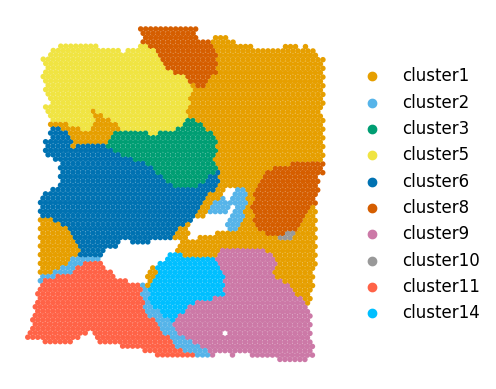

In [43]:
sc.pl.spatial(adata_com[4727:8525,:], img_key=None, color=['banksy_cluster'], title=[''],
                legend_fontsize=12, show=True, frameon=False, palette = pathology_color,
                spot_size=spot_size)

In [44]:
adata_com

AnnData object with n_obs × n_vars = 8525 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'slice', 'UMAP_1', 'UMAP_2', 'banksy_cluster'
    obsm: 'spatial', 'banksy_pca'

In [45]:
# adata_com.write('D:\ppppaper\data\IDC\BAS1_CD3_com_BANKSY.h5ad')

In [21]:
adata_1=sc.read_h5ad(r"D:/ppppaper/data/seqFISH/filtered_seqFish.h5ad")
adata_1.obs['annotation'] = adata_1.obs['celltype_mapped_refined']
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 11529 × 351
    obs: 'z', 'uniqueID', 'x_global', 'y_global', 'embryo', 'Estage', 'x_global_affine', 'y_global_affine', 'UMAP1', 'UMAP2', 'cluster', 'celltype_mapped_refined', 'celltype_mapped', 'annotation'
    var: 'gene_names'
    obsm: 'spatial'

In [22]:
adata_2=sc.read_h5ad(r"D:/ppppaper/data/Stereo_seq/filtered_Stereoseq.h5ad")
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 5031 × 25568
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clock', 'Re

In [23]:
adata_com = sc.concat([adata_1, adata_2], label='slice', keys=['seqFish', 'Stereoseq'])

In [24]:
adata_com

AnnData object with n_obs × n_vars = 16560 × 347
    obs: 'annotation', 'slice'
    obsm: 'spatial'

In [25]:
csv_data_3 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\crosstech_PCA_com.csv", index_col=0)
print(csv_data_3.head())

                               PC1       PC2       PC3       PC4       PC5  \
embryo2_Pos29_cell10_z2   2.859724  0.578717 -0.203253  0.020274  2.429432   
embryo2_Pos29_cell10_z5   4.616483  1.613180 -0.010814  0.736418  1.934771   
embryo2_Pos29_cell100_z2  4.945615  1.634930 -0.423719  0.435071  1.630459   
embryo2_Pos29_cell100_z5  3.716421  1.370054 -0.202756 -0.415395  1.051229   
embryo2_Pos29_cell101_z5  4.402134  2.406438 -0.151802  0.506971  2.356572   

                               PC6       PC7       PC8       PC9      PC10  \
embryo2_Pos29_cell10_z2  -1.011733  0.129211  0.692521  1.270629 -0.471098   
embryo2_Pos29_cell10_z5  -0.829059  1.315792 -1.211133  0.349828  0.331258   
embryo2_Pos29_cell100_z2 -1.608496  1.551160 -0.458140  0.272154  0.530678   
embryo2_Pos29_cell100_z5 -1.736316  2.216561  0.050707  0.637356 -0.345194   
embryo2_Pos29_cell101_z5 -1.402067  2.625862 -0.955155  0.355530 -0.443423   

                              PC11      PC12      PC13      PC

In [26]:
pca_array = csv_data_3.values  # 转换为NumPy数组
pca_array

array([[ 2.85972376,  0.57871712, -0.20325342, ..., -0.4247719 ,
         0.67314007,  0.08734713],
       [ 4.61648348,  1.61317994, -0.0108142 , ..., -0.28463332,
         1.30575437, -0.29447463],
       [ 4.94561497,  1.63492991, -0.42371939, ..., -0.93228779,
         0.01578955,  2.36363095],
       ...,
       [ 1.89167144,  1.34771474, -1.95751266, ..., -0.15392169,
         0.35914826,  0.25414228],
       [ 1.63903884,  1.37752605, -2.18452263, ...,  0.20926759,
        -0.04549234,  0.35570344],
       [ 1.84635816,  1.63696248, -1.98247741, ...,  0.38611273,
         0.36388096,  0.64084564]])

In [32]:
pca_array.shape

(16560, 20)

In [34]:
pca_array[0:11529,:].shape

(11529, 20)

In [60]:
pca_array[16557:16560,:]

array([[ 1.89167144,  1.34771474, -1.95751266,  0.83300439,  3.56348088,
        -0.96778359, -1.35478068,  1.15001356,  2.9312469 , -0.00884598,
         2.2524387 ,  0.60524857, -0.23122186,  1.01164916,  0.33362025,
         2.36735009,  0.87756532, -0.15392169,  0.35914826,  0.25414228],
       [ 1.63903884,  1.37752605, -2.18452263,  1.01699583,  3.20163572,
        -1.210836  , -1.55603551,  1.6710919 ,  2.7747013 ,  0.26582265,
         1.73588124,  0.57930049, -0.20206839,  0.56369002,  0.7503752 ,
         2.31123069,  1.14592506,  0.20926759, -0.04549234,  0.35570344],
       [ 1.84635816,  1.63696248, -1.98247741,  0.91711988,  3.73161856,
        -1.05636125, -1.06740158,  1.23854306,  2.81209549,  0.00530757,
         1.73666727,  0.8801018 , -0.24480376,  0.92595586,  0.63728432,
         2.75538607,  1.06412055,  0.38611273,  0.36388096,  0.64084564]])

In [53]:
pca_array[11529:16560,:].shape

(5031, 20)

In [27]:
adata_com.obsm["banksy_pca"] = pca_array

In [28]:
csv_data_2 = pd.read_csv(r"D:\ppppaper\BANKSY\bansy_R\Banksy-bioc\Banksy-bioc\crosstech_UMAP_com.csv", index_col=0)
# 查看映射后的列
print(csv_data_2.head())

                                 V1        V2
embryo2_Pos29_cell10_z2  -23.009380 -1.068637
embryo2_Pos29_cell10_z5  -23.585500 -0.368581
embryo2_Pos29_cell100_z2 -23.972479 -1.073000
embryo2_Pos29_cell100_z5 -23.539314 -0.991763
embryo2_Pos29_cell101_z5 -25.457165 -0.234710


In [29]:
UMAP_1 = csv_data_2[['V1']]
UMAP_2 = csv_data_2[['V2']]

print(UMAP_1.index.equals(adata_com.obs_names)) 
print(UMAP_2.index.equals(adata_com.obs_names)) 
adata_com.obs['UMAP_1'] = UMAP_1
adata_com.obs['UMAP_2'] = UMAP_2

True
True


In [17]:
adata_com.obsm["X_umap"] = adata_com.obs[['UMAP_1', 'UMAP_2']].values

In [31]:
adata_com

AnnData object with n_obs × n_vars = 16560 × 347
    obs: 'annotation', 'slice', 'UMAP_1', 'UMAP_2'
    obsm: 'spatial', 'banksy_pca'

In [61]:
embd0=adata_com.obsm["banksy_pca"][0:11529,:]
embd1=adata_com.obsm["banksy_pca"][11529:16560:,:]

In [62]:
true_labels_1 = adata_1.obs['annotation'].to_numpy()
true_labels_2 = adata_2.obs['annotation'].to_numpy()

best, index, distance = spatial_match([embd0, embd1], adatas=[adata_1, adata_2], reorder=False)
valid_indices = best < true_labels_1.size
valid_best = best[valid_indices]
valid_indices = np.arange(len(best))[valid_indices] 

aligned_true_labels_1 = true_labels_1[valid_best]
matched_labels_3 = true_labels_2[valid_indices]

# 计算 ARI 和 NMI
ari = adjusted_rand_score(aligned_true_labels_1, matched_labels_3)
nmi = normalized_mutual_info_score(aligned_true_labels_1, matched_labels_3)

print(f'ARI: {ari}, NMI: {nmi}')

ARI: 0.4905086044515109, NMI: 0.47565773650396576


In [63]:
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['annotation']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['annotation']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

In [66]:
sc.set_figure_params(dpi=300, dpi_save=300, transparent=True, facecolor=(1,1,1,1))

dataset1: 21 cell types; dataset2: 11 cell types; 
                    Total :29 celltypes; Overlap: 3 cell types 
                    Not overlap :[['Intermediate mesoderm', 'Lateral plate mesoderm', 'Anterior somitic tissues', 'Endothelium', 'Mixed mesenchymal mesoderm', 'Allantois', 'Forebrain/Midbrain/Hindbrain', 'Presomitic mesoderm', 'ExE endoderm', 'Haematoendothelial progenitors', 'NMP', 'Splanchnic mesoderm', 'Surface ectoderm', 'Cardiomyocytes', 'Cranial mesoderm', 'Erythroid', 'Blood progenitors', 'Definitive endoderm', 'AGM', 'Mesenchyme', 'Branchial arch', 'Heart', 'Notochord', 'Connective tissue', 'Liver', 'Brain']]
Subsampled 300 pairs from 5031


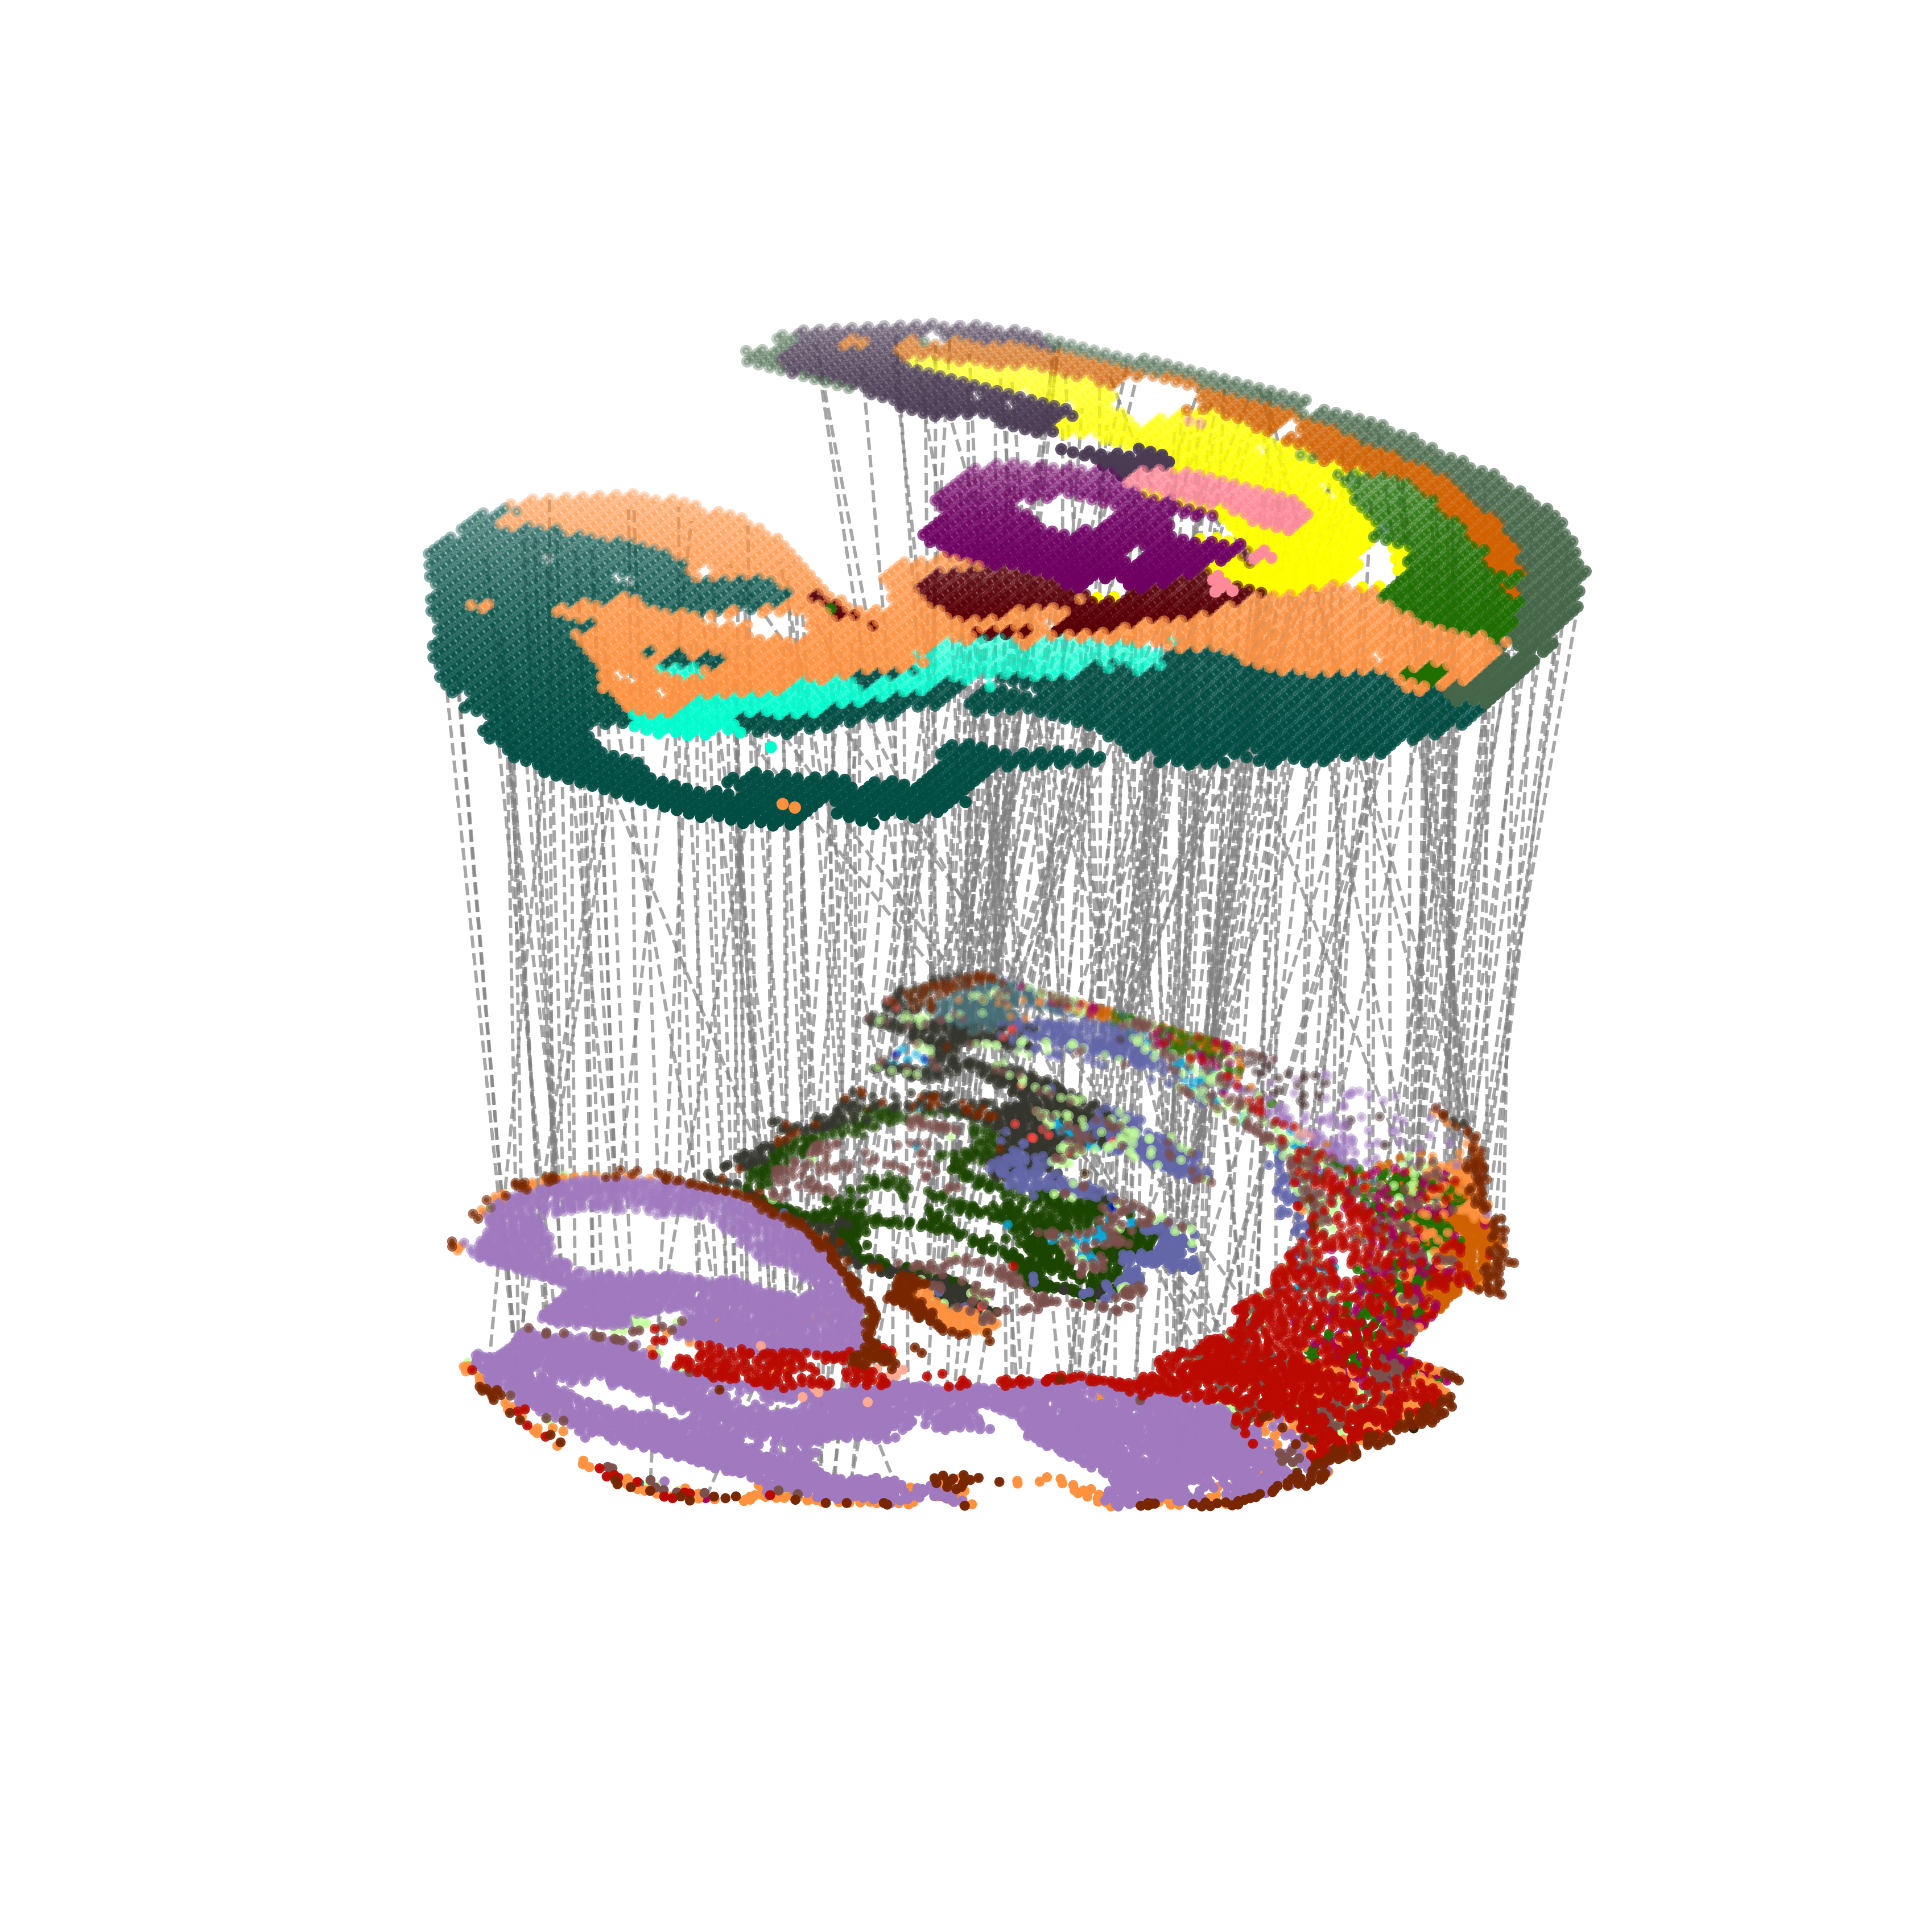

In [68]:
multi_align = match_3D_multi(adata1_df, adata2_df, matching, meta='celltype',
                             scale_coordinate=True, subsample_size=300, exchange_xy=False)

multi_align.draw_3D(size=[7, 8], line_width=0.7, line_color='grey', point_size=[1.25,2.5], 
                    hide_axis=True, show_error=False, save='./Alignment_3.png')

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


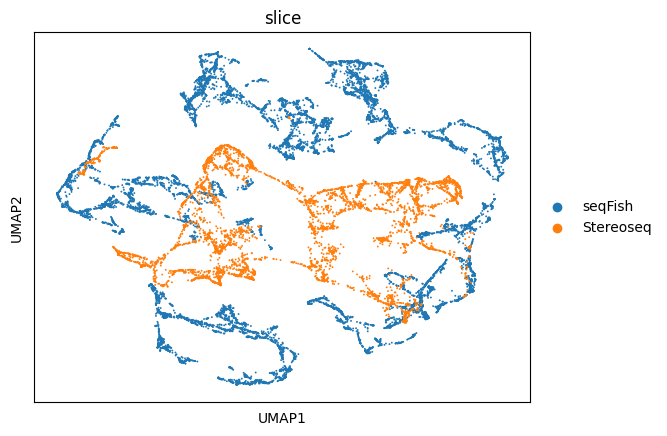

In [20]:
sc.pl.umap(adata_com, color=['slice'])

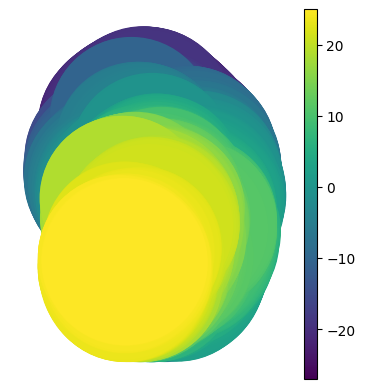

In [16]:
sc.pl.spatial(adata_com[0:11529,:], img_key=None, color=['UMAP_1'], title=[''],
                legend_fontsize=12, show=True, frameon=False, palette = pathology_color,
                spot_size=spot_size)

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


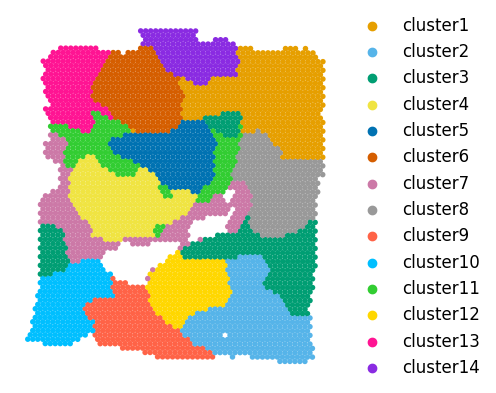

In [60]:
sc.pl.spatial(adata_com[3987:7786,:], img_key=None, color=['banksy_cluster'], title=[''],
                legend_fontsize=12, show=True, frameon=False, palette = pathology_color,
                spot_size=spot_size)

In [61]:
# adata_com.write('D:\ppppaper\data\IDC\BAS2_BAS1_com_BANKSY.h5ad')

In [2]:
adata_3 = sc.read_h5ad(r"D:\ppppaper\SpaGCN\IDC_BAS1_SpaGCN_14.h5ad")
adata_3.var_names_make_unique(join="++")
adata_3

AnnData object with n_obs × n_vars = 8525 × 36601
    obs: 'n_counts', 'x_pixel', 'y_pixel', 'dataset_batch', 'SpaGCN_pred'
    uns: 'SpaGCN_pred_colors', 'neighbors'
    obsm: 'SpaGCN_embd', 'spatial'
    obsp: 'connectivities', 'distances'

In [3]:
sc.pp.neighbors(adata_3, use_rep= 'SpaGCN_embd')
sc.tl.umap(adata_3)

d:\Anaconda\envs\scSLAT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


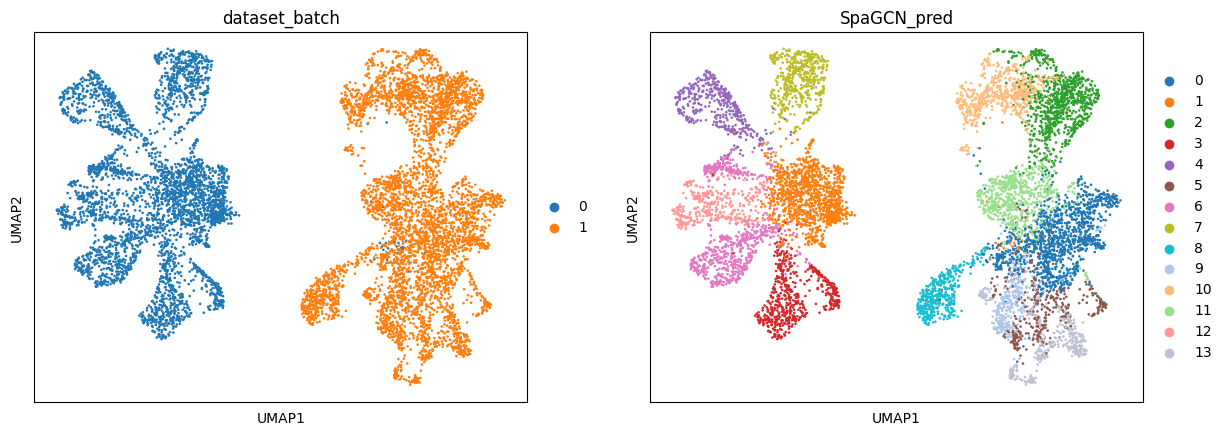

In [4]:
sc.pl.umap(adata_3, color= ['dataset_batch', 'SpaGCN_pred'])